In [ ]:
import os
import re
import shutil
from collections import defaultdict

IMG_EXTS = {'.jpg', '.jpeg', '.png'}

ts_regex = re.compile(r'_(\d+(?:\.\d+)?)\.(?:jpg|jpeg|png)$', re.IGNORECASE)

def parse_timestamp(filename: str):
    m = ts_regex.search(filename)
    if not m:
        return None
    try:
        return float(m.group(1))
    except ValueError:
        return None

def split_into_captures(base_dir: str, threshold_sec: float = 2.0, start_index: int = 1, DRY_RUN: bool = True):
    """
    base_dir 구조 예:
      base_dir/
        view1/
        view2/
        view3/
        view4/
        view5_Oak/
    결과:
      base_dir/
        Captures{N}/view1/*.jpg
        Captures{N}/view2/*.jpg
        ...
    """
    # 1) view 폴더 수집
    views = [d for d in os.listdir(base_dir)
             if os.path.isdir(os.path.join(base_dir, d)) and d.lower().startswith('view')]
    if not views:
        print(f"[WARN] view 폴더가 없습니다: {base_dir}")
        return

    # 2) 모든 view의 파일과 타임스탬프 수집
    all_items = []  # (timestamp, abs_path, view_name, filename)
    skipped = []
    for v in sorted(views):
        vdir = os.path.join(base_dir, v)
        for fname in os.listdir(vdir):
            ext = os.path.splitext(fname)[1].lower()
            if ext not in IMG_EXTS:
                continue
            ts = parse_timestamp(fname)
            if ts is None:
                skipped.append(os.path.join(vdir, fname))
                continue
            all_items.append((ts, os.path.join(vdir, fname), v, fname))

    if not all_items:
        print(f"[WARN] 처리할 이미지가 없습니다: {base_dir}")
        return

    # 3) 전역 타임스탬프 기준 정렬 후 세션 나누기
    all_items.sort(key=lambda x: x[0])  # by timestamp
    session_idx = start_index
    last_ts = None

    # 세션별/뷰별 카운트 집계와 이동 계획
    plan = []  # (src, dst)
    counts = defaultdict(lambda: defaultdict(int))  # counts[session][view] = n

    for ts, src, view, fname in all_items:
        if last_ts is None:
            pass
        else:
            if ts - last_ts >= threshold_sec:
                session_idx += 1
        last_ts = ts

        dest_dir = os.path.join(base_dir, f"Captures{session_idx}", view)
        os.makedirs(dest_dir, exist_ok=True)
        dest = os.path.join(dest_dir, fname)

        # 이름 충돌 시 뒤에 인덱스 부여
        if os.path.exists(dest):
            stem, ext = os.path.splitext(fname)
            k = 1
            while True:
                alt = os.path.join(dest_dir, f"{stem}__{k}{ext}")
                if not os.path.exists(alt):
                    dest = alt
                    break
                k += 1

        plan.append((src, dest))
        counts[f"Captures{session_idx}"][view] += 1

    # 4) 실행
    if DRY_RUN:
        print("=== DRY RUN (이동하지 않음) ===")
        print(f"- 기준 경로: {base_dir}")
        print(f"- 세션 시작 번호: {start_index}")
        print(f"- 세션 경계: 연속 프레임 간 {threshold_sec}초 이상")
        print(f"- 총 이동 예정 파일: {len(plan)}")
        for cap in sorted(counts.keys(), key=lambda s: int(re.search(r'\d+', s).group())):
            total = sum(counts[cap].values())
            per_view = ", ".join(f"{v}:{counts[cap][v]}" for v in sorted(counts[cap].keys()))
            print(f"  {cap} → {total} files ({per_view})")
        if skipped:
            print(f"\n[참고] 타임스탬프 파싱 실패 {len(skipped)}건(확인 요망). 예시 3개:")
            for s in skipped[:3]:
                print("   -", s)
    else:
        for src, dst in plan:
            shutil.move(src, dst)
        print("✅ 완료!")
        for cap in sorted(counts.keys(), key=lambda s: int(re.search(r'\d+', s).group())):
            total = sum(counts[cap].values())
            per_view = ", ".join(f"{v}:{counts[cap][v]}" for v in sorted(counts[cap].keys()))
            print(f"  {cap} → {total} files ({per_view})")
        if skipped:
            print(f"\n[참고] 타임스탬프 파싱 실패 {len(skipped)}건. 수동 확인 필요.")


# ===== 사용 예시 =====
# 1) ZED_Captures1-3 → Captures1, Captures2, Captures3 ... (1부터 시작)
# 먼저 계획만 확인:
# split_into_captures("/home/najo/NAS/VLA/dataset/ZED_Captures1-3", threshold_sec=12.0, start_index=1, DRY_RUN=True)
# split_into_captures("/home/najo/NAS/VLA/dataset/ZED_Captures4-5", threshold_sec=12.0, start_index=4, DRY_RUN=True)
# split_into_captures("/home/najo/NAS/VLA/dataset/ZED_Captures6-7", threshold_sec=12.0, start_index=6, DRY_RUN=True)
# 문제 없으면 실제 이동:
# split_into_captures("/home/najo/NAS/VLA/dataset/ZED_Captures1-3", threshold_sec=12.0, start_index=1, DRY_RUN=False)
# split_into_captures("/home/najo/NAS/VLA/dataset/ZED_Captures4-5", threshold_sec=12.0, start_index=4, DRY_RUN=False)
# split_into_captures("/home/najo/NAS/VLA/dataset/ZED_Captures6-7", threshold_sec=12.0, start_index=6, DRY_RUN=False)


In [4]:
import os
import shutil

base_dir = "/home/najo/NAS/VLA/dataset/OCT_insertion"
capture_range = range(1, 8)  # Capture1 ~ Capture7
views = [f"view{i}" for i in range(1, 5)]  # view1 ~ view4

for cap_idx in capture_range:
    capture_path = os.path.join(base_dir, f"Captures{cap_idx}")
    if not os.path.exists(capture_path):
        print(f"⚠️ {capture_path} 없음, 건너뜀")
        continue

    print(f"📂 처리 중: {capture_path}")
    for view in views:
        view_path = os.path.join(capture_path, view)
        if not os.path.exists(view_path):
            print(f"  └─ ⚠️ {view_path} 없음, 건너뜀")
            continue

        left_dir = os.path.join(view_path, "left")
        right_dir = os.path.join(view_path, "right")
        os.makedirs(left_dir, exist_ok=True)
        os.makedirs(right_dir, exist_ok=True)

        # 파일 순회하면서 left/right 구분 이동
        for fname in os.listdir(view_path):
            fpath = os.path.join(view_path, fname)
            if not os.path.isfile(fpath):
                continue
            lower = fname.lower()
            if "_left_" in lower:
                shutil.move(fpath, os.path.join(left_dir, fname))
            elif "_right_" in lower:
                shutil.move(fpath, os.path.join(right_dir, fname))

        print(f"  ├─ view: {view} → left/right 분류 완료")

print("✅ 모든 Capture(1~7) 정리 완료!")

📂 처리 중: /home/najo/NAS/VLA/dataset/OCT_insertion/Captures1
  ├─ view: view1 → left/right 분류 완료
  ├─ view: view2 → left/right 분류 완료
  ├─ view: view3 → left/right 분류 완료
  ├─ view: view4 → left/right 분류 완료
📂 처리 중: /home/najo/NAS/VLA/dataset/OCT_insertion/Captures2
  ├─ view: view1 → left/right 분류 완료
  ├─ view: view2 → left/right 분류 완료
  ├─ view: view3 → left/right 분류 완료
  ├─ view: view4 → left/right 분류 완료
📂 처리 중: /home/najo/NAS/VLA/dataset/OCT_insertion/Captures3
  ├─ view: view1 → left/right 분류 완료
  ├─ view: view2 → left/right 분류 완료
  ├─ view: view3 → left/right 분류 완료
  ├─ view: view4 → left/right 분류 완료
📂 처리 중: /home/najo/NAS/VLA/dataset/OCT_insertion/Captures4


  ├─ view: view1 → left/right 분류 완료
  ├─ view: view2 → left/right 분류 완료
  ├─ view: view3 → left/right 분류 완료
  ├─ view: view4 → left/right 분류 완료
📂 처리 중: /home/najo/NAS/VLA/dataset/OCT_insertion/Captures5
  ├─ view: view1 → left/right 분류 완료
  ├─ view: view2 → left/right 분류 완료
  ├─ view: view3 → left/right 분류 완료
  ├─ view: view4 → left/right 분류 완료
📂 처리 중: /home/najo/NAS/VLA/dataset/OCT_insertion/Captures6
  ├─ view: view1 → left/right 분류 완료
  ├─ view: view2 → left/right 분류 완료
  ├─ view: view3 → left/right 분류 완료
  ├─ view: view4 → left/right 분류 완료
📂 처리 중: /home/najo/NAS/VLA/dataset/OCT_insertion/Captures7
  ├─ view: view1 → left/right 분류 완료
  ├─ view: view2 → left/right 분류 완료
  ├─ view: view3 → left/right 분류 완료
  ├─ view: view4 → left/right 분류 완료
✅ 모든 Capture(1~7) 정리 완료!


In [5]:
import os
import shutil

base_dir = "/home/najo/NAS/VLA/dataset/part2"
capture_range = range(11, 21)  # Capture1 ~ Capture7
views = [f"view{i}" for i in range(1, 5)]  # view1 ~ view4

for cap_idx in capture_range:
    capture_path = os.path.join(base_dir, f"ZED_Captures_{cap_idx}th")
    if not os.path.exists(capture_path):
        print(f"⚠️ {capture_path} 없음, 건너뜀")
        continue

    print(f"📂 처리 중: {capture_path}")
    for view in views:
        view_path = os.path.join(capture_path, view)
        if not os.path.exists(view_path):
            print(f"  └─ ⚠️ {view_path} 없음, 건너뜀")
            continue

        left_dir = os.path.join(view_path, "left")
        right_dir = os.path.join(view_path, "right")
        os.makedirs(left_dir, exist_ok=True)
        os.makedirs(right_dir, exist_ok=True)

        # 파일 순회하면서 left/right 구분 이동
        for fname in os.listdir(view_path):
            fpath = os.path.join(view_path, fname)
            if not os.path.isfile(fpath):
                continue
            lower = fname.lower()
            if "_left_" in lower:
                shutil.move(fpath, os.path.join(left_dir, fname))
            elif "_right_" in lower:
                shutil.move(fpath, os.path.join(right_dir, fname))

        print(f"  ├─ view: {view} → left/right 분류 완료")

print("✅ 모든 Capture(1~11) 정리 완료!")

📂 처리 중: /home/najo/NAS/VLA/dataset/part2/ZED_Captures_11th
  ├─ view: view1 → left/right 분류 완료
  ├─ view: view2 → left/right 분류 완료
  ├─ view: view3 → left/right 분류 완료
  ├─ view: view4 → left/right 분류 완료
📂 처리 중: /home/najo/NAS/VLA/dataset/part2/ZED_Captures_12th
  ├─ view: view1 → left/right 분류 완료
  ├─ view: view2 → left/right 분류 완료
  ├─ view: view3 → left/right 분류 완료
  ├─ view: view4 → left/right 분류 완료
📂 처리 중: /home/najo/NAS/VLA/dataset/part2/ZED_Captures_13th
  ├─ view: view1 → left/right 분류 완료
  ├─ view: view2 → left/right 분류 완료
  ├─ view: view3 → left/right 분류 완료
  ├─ view: view4 → left/right 분류 완료
📂 처리 중: /home/najo/NAS/VLA/dataset/part2/ZED_Captures_14th
  ├─ view: view1 → left/right 분류 완료
  ├─ view: view2 → left/right 분류 완료
  ├─ view: view3 → left/right 분류 완료
  ├─ view: view4 → left/right 분류 완료
📂 처리 중: /home/najo/NAS/VLA/dataset/part2/ZED_Captures_15th
  ├─ view: view1 → left/right 분류 완료
  ├─ view: view2 → left/right 분류 완료
  ├─ view: view3 → left/right 분류 완료
  ├─ view: view4 → le

### Time Stamp dataset matching

In [1]:
import os
import glob
import csv
import json
import bisect
import numpy as np
from pathlib import Path


def load_robot_csv(csv_path):
    """로봇 CSV 파싱 (timestamp + joint angles + EE pose)"""
    timestamps, data = [], []
    with open(csv_path, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            ts = float(row["epoch_s"])
            timestamps.append(ts)
            data.append({
                "timestamp": ts,
                "joint_angles": [float(row[f"joint_angle_{i}"]) for i in range(1, 7)],
                "ee_pose": [float(row[f]) for f in ["EE_x", "EE_y", "EE_z", "EE_a", "EE_b", "EE_r"]],
            })
    return timestamps, data


def extract_timestamp(img_path: str):
    """이미지 파일명에서 timestamp 추출"""
    try:
        return float(Path(img_path).stem.split('_')[-1])
    except ValueError:
        return None


def get_closest_item(ts_list, target_ts):
    """이진탐색으로 가장 가까운 timestamp의 인덱스 반환"""
    idx = bisect.bisect_left(ts_list, target_ts)
    if idx == 0:
        return 0
    if idx >= len(ts_list):
        return len(ts_list) - 1
    before, after = ts_list[idx - 1], ts_list[idx]
    return idx - 1 if abs(before - target_ts) < abs(after - target_ts) else idx


def get_closest_robot_state(ts_list, robot_data, ts_img):
    """로봇 상태 중 가장 가까운 시점 반환"""
    idx = get_closest_item(ts_list, ts_img)
    return robot_data[idx]


def build_singleview_dataset_sync(episode_dir, max_diff_s=0.010, save_json=True):
    """
    ✅ 각 카메라(viewX_side)별로 독립 JSON 생성
    ✅ Δt(robot) ≤ 10ms 유지
    ✅ 카메라 간 동기화는 고려하지 않음
    """
    episode_dir = Path(episode_dir)
    csv_path = next(episode_dir.glob("robot_rt_*.csv"))
    ts_list, robot_data = load_robot_csv(csv_path)

    # --- view 폴더 탐색 ---
    views = sorted([p for p in episode_dir.iterdir() if p.is_dir() and "view" in p.name])
    all_view_keys = []
    for view in views:
        for side in ["left", "right"]:
            all_view_keys.append(f"{view.name}_{side}")

    for key in all_view_keys:
        view, side = key.split("_")
        img_dir = episode_dir / view / side
        img_paths = sorted(glob.glob(str(img_dir / "*.jpg")))

        if len(img_paths) == 0:
            print(f"⚠️ No images found for {key}")
            continue

        timestamps = [extract_timestamp(p) for p in img_paths if extract_timestamp(p) is not None]
        if len(timestamps) == 0:
            print(f"⚠️ No valid timestamps for {key}")
            continue

        dataset = []
        filtered_time = 0

        for img_path, ts_img in zip(img_paths, timestamps):
            robot_state = get_closest_robot_state(ts_list, robot_data, ts_img)
            diff_robot = abs(robot_state["timestamp"] - ts_img)
            if diff_robot > max_diff_s:
                filtered_time += 1
                continue

            dataset.append({
                "timestamp": ts_img,
                "image": str(Path(img_path).resolve()),
                "robot_state": robot_state,
                "time_diff_robot": diff_robot,
            })

        print(f"\n[📸 Single-view Sync Report: {key}]")
        print(f" - Total frames: {len(img_paths)}")
        print(f" - Kept: {len(dataset)}")
        print(f" - Filtered Δt(robot)>10ms: {filtered_time}")

        # --- JSON 저장 ---
        if save_json and len(dataset) > 0:
            out_path = episode_dir / f"{episode_dir.name}_{key}_single.json"
            with open(out_path, "w") as f:
                json.dump(dataset, f, indent=2)
            print(f"[💾 Saved] {out_path} ({len(dataset)} valid samples)")

    print(f"\n✅ Completed: {episode_dir.name}")


# === 실행 예시 ===
for i in range(1, 21):
    build_singleview_dataset_sync(
        f"/home/najo/NAS/VLA/dataset/part{1 if i<=10 else 2}/ZED_Captures_{i}th",
        max_diff_s=0.010,   # 로봇-이미지 오차 ≤ 10ms
        save_json=True
    )



[📸 Single-view Sync Report: view1_left]
 - Total frames: 450
 - Kept: 449
 - Filtered Δt(robot)>10ms: 1
[💾 Saved] /home/najo/NAS/VLA/dataset/part1/ZED_Captures_1th/ZED_Captures_1th_view1_left_single.json (449 valid samples)

[📸 Single-view Sync Report: view1_right]
 - Total frames: 450
 - Kept: 449
 - Filtered Δt(robot)>10ms: 1
[💾 Saved] /home/najo/NAS/VLA/dataset/part1/ZED_Captures_1th/ZED_Captures_1th_view1_right_single.json (449 valid samples)

[📸 Single-view Sync Report: view2_left]
 - Total frames: 443
 - Kept: 442
 - Filtered Δt(robot)>10ms: 1
[💾 Saved] /home/najo/NAS/VLA/dataset/part1/ZED_Captures_1th/ZED_Captures_1th_view2_left_single.json (442 valid samples)

[📸 Single-view Sync Report: view2_right]
 - Total frames: 443
 - Kept: 442
 - Filtered Δt(robot)>10ms: 1
[💾 Saved] /home/najo/NAS/VLA/dataset/part1/ZED_Captures_1th/ZED_Captures_1th_view2_right_single.json (442 valid samples)

[📸 Single-view Sync Report: view3_left]
 - Total frames: 446
 - Kept: 446
 - Filtered Δt(robot)

In [2]:
import os
import glob
import csv
import json
import bisect
import numpy as np
from pathlib import Path


def load_robot_csv(csv_path):
    """로봇 CSV 파싱 (timestamp + joint angles + EE pose)"""
    timestamps, data = [], []
    with open(csv_path, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            ts = float(row["epoch_s"])
            timestamps.append(ts)
            data.append({
                "timestamp": ts,
                "joint_angles": [float(row[f"joint_angle_{i}"]) for i in range(1, 7)],
                "ee_pose": [float(row[f]) for f in ["EE_x", "EE_y", "EE_z", "EE_a", "EE_b", "EE_r"]],
            })
    return timestamps, data


def extract_timestamp(img_path: str):
    """이미지 파일명에서 timestamp 추출"""
    try:
        return float(Path(img_path).stem.split('_')[-1])
    except ValueError:
        return None


def get_closest_item(ts_list, target_ts):
    """이진탐색으로 가장 가까운 timestamp의 인덱스 반환"""
    idx = bisect.bisect_left(ts_list, target_ts)
    if idx == 0:
        return 0
    if idx >= len(ts_list):
        return len(ts_list) - 1
    before, after = ts_list[idx - 1], ts_list[idx]
    return idx - 1 if abs(before - target_ts) < abs(after - target_ts) else idx


def get_closest_robot_state(ts_list, robot_data, ts_img):
    """로봇 상태 중 가장 가까운 시점 반환"""
    idx = get_closest_item(ts_list, ts_img)
    return robot_data[idx]


def build_singleview_dataset_sync_v5(episode_dir, max_diff_s=0.010, save_json=True):
    """
    ✅ 각 카메라(viewX_side, view5_oak)별로 독립 JSON 생성
    ✅ Δt(robot) ≤ 10ms 유지
    ✅ 카메라 간 동기화는 고려하지 않음
    """
    episode_dir = Path(episode_dir)
    csv_path = next(episode_dir.glob("robot_rt_*.csv"))
    ts_list, robot_data = load_robot_csv(csv_path)

    # --- 카메라 폴더 구조 ---
    views = sorted([p for p in episode_dir.iterdir() if p.is_dir() and "view" in p.name])
    all_view_keys = []

    for view in views:
        if view.name == "view5_oak":
            all_view_keys.append("view5_oak")
        else:
            for side in ["left", "right"]:
                all_view_keys.append(f"{view.name}_{side}")

    for key in all_view_keys:
        if key == "view5_oak":
            img_paths = sorted(glob.glob(str(episode_dir / "view5_oak" / "*.jpg")))
        else:
            view, side = key.split("_")
            img_paths = sorted(glob.glob(str(episode_dir / view / side / "*.jpg")))

        if len(img_paths) == 0:
            print(f"⚠️ No images found for {key}")
            continue

        timestamps = [extract_timestamp(p) for p in img_paths if extract_timestamp(p) is not None]
        if len(timestamps) == 0:
            print(f"⚠️ No valid timestamps for {key}")
            continue

        dataset = []
        filtered_time = 0

        for img_path, ts_img in zip(img_paths, timestamps):
            robot_state = get_closest_robot_state(ts_list, robot_data, ts_img)
            diff_robot = abs(robot_state["timestamp"] - ts_img)
            if diff_robot > max_diff_s:
                filtered_time += 1
                continue

            dataset.append({
                "timestamp": ts_img,
                "image": str(Path(img_path).resolve()),
                "robot_state": robot_state,
                "time_diff_robot": diff_robot,
            })

        print(f"\n[📸 Single-view Sync Report: {key}]")
        print(f" - Total frames: {len(img_paths)}")
        print(f" - Kept: {len(dataset)}")
        print(f" - Filtered Δt(robot)>10ms: {filtered_time}")

        # --- JSON 저장 ---
        if save_json and len(dataset) > 0:
            out_path = episode_dir / f"{episode_dir.name}_{key}_single.json"
            with open(out_path, "w") as f:
                json.dump(dataset, f, indent=2)
            print(f"[💾 Saved] {out_path} ({len(dataset)} valid samples)")

    print(f"\n✅ Completed: {episode_dir.name}")


# === 실행 예시 ===
for i in range(1, 8):
    build_singleview_dataset_sync_v5(
        f"/home/najo/NAS/VLA/dataset/OCT_insertion/Captures{i}",
        max_diff_s=0.010,   # 로봇-이미지 오차 ≤ 10ms
        save_json=True
    )



[📸 Single-view Sync Report: view1_left]
 - Total frames: 397
 - Kept: 395
 - Filtered Δt(robot)>10ms: 2
[💾 Saved] /home/najo/NAS/VLA/dataset/OCT_insertion/Captures1/Captures1_view1_left_single.json (395 valid samples)

[📸 Single-view Sync Report: view1_right]
 - Total frames: 397
 - Kept: 395
 - Filtered Δt(robot)>10ms: 2
[💾 Saved] /home/najo/NAS/VLA/dataset/OCT_insertion/Captures1/Captures1_view1_right_single.json (395 valid samples)

[📸 Single-view Sync Report: view2_left]
 - Total frames: 393
 - Kept: 391
 - Filtered Δt(robot)>10ms: 2
[💾 Saved] /home/najo/NAS/VLA/dataset/OCT_insertion/Captures1/Captures1_view2_left_single.json (391 valid samples)

[📸 Single-view Sync Report: view2_right]
 - Total frames: 393
 - Kept: 391
 - Filtered Δt(robot)>10ms: 2
[💾 Saved] /home/najo/NAS/VLA/dataset/OCT_insertion/Captures1/Captures1_view2_right_single.json (391 valid samples)

[📸 Single-view Sync Report: view3_left]
 - Total frames: 392
 - Kept: 390
 - Filtered Δt(robot)>10ms: 2
[💾 Saved] /home

### Multi-view time stamp

In [32]:
import os
import glob
import csv
import json
import bisect
import numpy as np
from pathlib import Path


def load_robot_csv(csv_path):
    """로봇 CSV 파싱 (timestamp + joint angles + EE pose)"""
    timestamps, data = [], []
    with open(csv_path, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            ts = float(row["epoch_s"])
            timestamps.append(ts)
            data.append({
                "timestamp": ts,
                "joint_angles": [float(row[f"joint_angle_{i}"]) for i in range(1, 7)],
                "ee_pose": [float(row[f]) for f in ["EE_x","EE_y","EE_z","EE_a","EE_b","EE_r"]],
            })
    return timestamps, data


def extract_timestamp(img_path: str):
    """이미지 파일명에서 timestamp 추출"""
    try:
        return float(Path(img_path).stem.split('_')[-1])
    except ValueError:
        return None


def get_closest_item(ts_list, target_ts):
    """이진탐색으로 가장 가까운 timestamp의 인덱스 반환"""
    idx = bisect.bisect_left(ts_list, target_ts)
    if idx == 0:
        return 0
    if idx >= len(ts_list):
        return len(ts_list) - 1
    before, after = ts_list[idx - 1], ts_list[idx]
    return idx - 1 if abs(before - target_ts) < abs(after - target_ts) else idx


def get_closest_robot_state(ts_list, robot_data, ts_img):
    """로봇 상태 중 가장 가까운 시점 반환"""
    idx = get_closest_item(ts_list, ts_img)
    return robot_data[idx]


def build_multiview_dataset_precise_sync(
    episode_dir,
    max_diff_s=0.010,
    view_sync_threshold=0.010,
    require_full_set=True,
    save_json=True
):
    """
    ✅ 기준 카메라(view1_left)의 타임스탬프에 대해
       각 카메라(viewX_side)에서 가장 가까운 프레임을 선택 (시간 오차 최소화)
    ✅ Δt(robot) ≤ 10ms 유지
    ✅ Δt(view 간) ≤ view_sync_threshold 유지
    ✅ require_full_set=True → 8장 완전 세트만 유지
    """
    episode_dir = Path(episode_dir)
    csv_path = next(episode_dir.glob("robot_rt_*.csv"))
    ts_list, robot_data = load_robot_csv(csv_path)

    # --- 각 카메라별 이미지 로드 및 타임스탬프 정렬 ---
    views = sorted([p for p in episode_dir.iterdir() if p.is_dir() and "view" in p.name])
    image_groups = {}
    for view in views:
        for side in ["left", "right"]:
            key = f"{view.name}_{side}"
            img_paths = sorted(glob.glob(str(view / side / "*.jpg")))
            timestamps = [extract_timestamp(p) for p in img_paths]
            image_groups[key] = {"paths": img_paths, "timestamps": timestamps}

    if "view1_left" not in image_groups:
        raise RuntimeError("view1_left 이미지가 기준이므로 폴더 구조를 확인하세요.")

    base_ts = image_groups["view1_left"]["timestamps"]
    base_paths = image_groups["view1_left"]["paths"]
    print(f"[📸 기준 카메라: view1_left, 총 {len(base_paths)} 프레임]")

    dataset = []
    filtered_time, filtered_unsync, filtered_missing = 0, 0, 0
    all_view_diffs = []

    for i, ts_ref in enumerate(base_ts):
        if ts_ref is None:
            continue

        # --- 각 카메라별로 가장 가까운 프레임 선택 ---
        step_images, timestamps = {}, []
        for key, group in image_groups.items():
            if not group["timestamps"]:
                step_images[key] = None
                continue
            idx_closest = get_closest_item(group["timestamps"], ts_ref)
            ts_match = group["timestamps"][idx_closest]
            step_images[key] = str(Path(group["paths"][idx_closest]).resolve())
            timestamps.append(ts_match)

        # --- 완전 세트 조건 ---
        if require_full_set and any(v is None for v in step_images.values()):
            filtered_missing += 1
            continue

        # --- view 간 타임스탬프 차이 ---
        if len(timestamps) >= 2:
            dt_view = max(timestamps) - min(timestamps)
            if dt_view > view_sync_threshold:
                filtered_unsync += 1
                continue
            all_view_diffs.append(dt_view)
        else:
            continue

        # --- 로봇 매칭 ---
        robot_state = get_closest_robot_state(ts_list, robot_data, ts_ref)
        diff_robot = abs(robot_state["timestamp"] - ts_ref)
        if diff_robot > max_diff_s:
            filtered_time += 1
            continue

        dataset.append({
            "timestamp_ref": ts_ref,
            "images": step_images,
            "robot_state": robot_state,
            "time_diff_robot": diff_robot,
            "time_diff_view": dt_view
        })

    # --- 통계 ---
    print(f"\n[🧠 Multi-view Precise Sync Report: {episode_dir.name}]")
    print(f" - Total frames: {len(base_paths)}")
    print(f" - Kept: {len(dataset)}")
    print(f" - Filtered Δt(robot)>10ms: {filtered_time}")
    print(f" - Filtered unsynced views: {filtered_unsync}")
    if require_full_set:
        print(f" - Filtered missing imgs: {filtered_missing}")

    if len(all_view_diffs) > 0:
        diffs = np.array(all_view_diffs)
        print("\n[📊 View Δt Stats]")
        print(f" - Mean Δt_view:   {np.mean(diffs)*1000:.3f} ms")
        print(f" - Median Δt_view: {np.median(diffs)*1000:.3f} ms")
        print(f" - Max Δt_view:    {np.max(diffs)*1000:.3f} ms")
        print(f" - 95th Δt_view:   {np.percentile(diffs, 95)*1000:.3f} ms")

    # --- JSON 저장 ---
    if save_json and len(dataset) > 0:
        postfix = "_precise_8views" if require_full_set else "_precise_partial_ok"
        out_path = episode_dir / f"{episode_dir.name}{postfix}.json"
        with open(out_path, "w") as f:
            json.dump(dataset, f, indent=2)
        print(f"[💾 Saved] {out_path} ({len(dataset)} valid samples)")

    return dataset, all_view_diffs


for i in range(1, 11):
    build_multiview_dataset_precise_sync(
        f"/home/najo/NAS/VLA/dataset/part1/ZED_Captures_{i}th",
        max_diff_s=0.010,          # 로봇-이미지 오차 ≤ 10ms
        view_sync_threshold=0.1, # view 간 동기화 오차 ≤ 100ms
        require_full_set=True
    )

for i in range(11, 21):
    build_multiview_dataset_precise_sync(
        f"/home/najo/NAS/VLA/dataset/part2/ZED_Captures_{i}th",
        max_diff_s=0.010,          # 로봇-이미지 오차 ≤ 10ms
        view_sync_threshold=0.1, # view 간 동기화 오차 ≤ 100ms
        require_full_set=True
    )

[📸 기준 카메라: view1_left, 총 450 프레임]

[🧠 Multi-view Precise Sync Report: ZED_Captures_1th]
 - Total frames: 450
 - Kept: 442
 - Filtered Δt(robot)>10ms: 1
 - Filtered unsynced views: 7
 - Filtered missing imgs: 0

[📊 View Δt Stats]
 - Mean Δt_view:   54.079 ms
 - Median Δt_view: 53.000 ms
 - Max Δt_view:    100.000 ms
 - 95th Δt_view:   90.000 ms
[💾 Saved] /home/najo/NAS/VLA/dataset/part1/ZED_Captures_1th/ZED_Captures_1th_precise_8views.json (442 valid samples)
[📸 기준 카메라: view1_left, 총 443 프레임]

[🧠 Multi-view Precise Sync Report: ZED_Captures_2th]
 - Total frames: 443
 - Kept: 427
 - Filtered Δt(robot)>10ms: 0
 - Filtered unsynced views: 16
 - Filtered missing imgs: 0

[📊 View Δt Stats]
 - Mean Δt_view:   54.136 ms
 - Median Δt_view: 51.000 ms
 - Max Δt_view:    100.000 ms
 - 95th Δt_view:   90.000 ms
[💾 Saved] /home/najo/NAS/VLA/dataset/part1/ZED_Captures_2th/ZED_Captures_2th_precise_8views.json (427 valid samples)
[📸 기준 카메라: view1_left, 총 439 프레임]

[🧠 Multi-view Precise Sync Report: ZED

In [43]:
import os
import glob
import csv
import json
import bisect
import numpy as np
from pathlib import Path


def load_robot_csv(csv_path):
    """로봇 CSV 파싱 (timestamp + joint angles + EE pose)"""
    timestamps, data = [], []
    with open(csv_path, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            ts = float(row["epoch_s"])
            timestamps.append(ts)
            data.append({
                "timestamp": ts,
                "joint_angles": [float(row[f"joint_angle_{i}"]) for i in range(1, 7)],
                "ee_pose": [float(row[f]) for f in ["EE_x","EE_y","EE_z","EE_a","EE_b","EE_r"]],
            })
    return timestamps, data


def extract_timestamp(img_path: str):
    """이미지 파일명에서 timestamp 추출"""
    try:
        return float(Path(img_path).stem.split('_')[-1])
    except ValueError:
        return None


def get_closest_item(ts_list, target_ts):
    """이진탐색으로 가장 가까운 timestamp 인덱스 반환"""
    idx = bisect.bisect_left(ts_list, target_ts)
    if idx == 0:
        return 0
    if idx >= len(ts_list):
        return len(ts_list) - 1
    before, after = ts_list[idx - 1], ts_list[idx]
    return idx - 1 if abs(before - target_ts) < abs(after - target_ts) else idx


def get_closest_robot_state(ts_list, robot_data, ts_img):
    """로봇 상태 중 가장 가까운 시점 반환"""
    idx = get_closest_item(ts_list, ts_img)
    return robot_data[idx]


def build_multiview_dataset_precise_sync_v5(
    episode_dir,
    max_diff_s=0.010,
    view_sync_threshold=0.010,
    require_full_set=True,
    save_json=True
):
    """
    ✅ view1_left 기준으로 동기화
    ✅ view1~4의 left/right + view5_oak = 9장
    ✅ Δt(robot) ≤ 10ms, Δt(view 간) ≤ 10ms 유지
    ✅ require_full_set=True → 9장 모두 존재할 때만 포함
    """
    episode_dir = Path(episode_dir)
    csv_path = next(episode_dir.glob("robot_rt_*.csv"))
    ts_list, robot_data = load_robot_csv(csv_path)

    # --- 카메라 폴더 구조 ---
    views = sorted([p for p in episode_dir.iterdir() if p.is_dir() and "view" in p.name])
    image_groups = {}

    for view in views:
        if view.name == "view5_oak":
            # OAK 카메라는 single camera
            img_paths = sorted(glob.glob(str(view / "*.jpg")))
            timestamps = [extract_timestamp(p) for p in img_paths]
            image_groups["view5_oak"] = {"paths": img_paths, "timestamps": timestamps}
        else:
            for side in ["left", "right"]:
                key = f"{view.name}_{side}"
                img_paths = sorted(glob.glob(str(view / side / "*.jpg")))
                timestamps = [extract_timestamp(p) for p in img_paths]
                image_groups[key] = {"paths": img_paths, "timestamps": timestamps}

    if "view1_left" not in image_groups:
        raise RuntimeError("view1_left 이미지가 기준이므로 폴더 구조를 확인하세요.")

    base_ts = image_groups["view1_left"]["timestamps"]
    base_paths = image_groups["view1_left"]["paths"]
    print(f"[📸 기준 카메라: view1_left, 총 {len(base_paths)} 프레임]")

    dataset = []
    filtered_time, filtered_unsync, filtered_missing = 0, 0, 0
    all_view_diffs = []

    for i, ts_ref in enumerate(base_ts):
        if ts_ref is None:
            continue

        # --- 각 카메라별로 가장 가까운 프레임 선택 ---
        step_images, timestamps = {}, []
        for key, group in image_groups.items():
            if not group["timestamps"]:
                step_images[key] = None
                continue
            idx_closest = get_closest_item(group["timestamps"], ts_ref)
            ts_match = group["timestamps"][idx_closest]
            step_images[key] = str(Path(group["paths"][idx_closest]).resolve())
            timestamps.append(ts_match)

        # --- 완전 세트 조건 ---
        if require_full_set and any(v is None for v in step_images.values()):
            filtered_missing += 1
            continue

        # --- view 간 타임스탬프 차이 ---
        if len(timestamps) >= 2:
            dt_view = max(timestamps) - min(timestamps)
            if dt_view > view_sync_threshold:
                filtered_unsync += 1
                continue
            all_view_diffs.append(dt_view)
        else:
            continue

        # --- 로봇 매칭 ---
        robot_state = get_closest_robot_state(ts_list, robot_data, ts_ref)
        diff_robot = abs(robot_state["timestamp"] - ts_ref)
        if diff_robot > max_diff_s:
            filtered_time += 1
            continue

        dataset.append({
            "timestamp_ref": ts_ref,
            "images": step_images,
            "robot_state": robot_state,
            "time_diff_robot": diff_robot,
            "time_diff_view": dt_view
        })

    # --- 통계 출력 ---
    print(f"\n[🧠 Multi-view (9-View) Sync Report: {episode_dir.name}]")
    print(f" - Total frames: {len(base_paths)}")
    print(f" - Kept: {len(dataset)}")
    print(f" - Filtered Δt(robot)>10ms: {filtered_time}")
    print(f" - Filtered unsynced views: {filtered_unsync}")
    print(f" - Filtered missing imgs: {filtered_missing}")

    if len(all_view_diffs) > 0:
        diffs = np.array(all_view_diffs)
        print("\n[📊 View Δt Stats]")
        print(f" - Mean Δt_view:   {np.mean(diffs)*1000:.3f} ms")
        print(f" - Median Δt_view: {np.median(diffs)*1000:.3f} ms")
        print(f" - Max Δt_view:    {np.max(diffs)*1000:.3f} ms")
        print(f" - 95th Δt_view:   {np.percentile(diffs, 95)*1000:.3f} ms")

    # --- JSON 저장 ---
    if save_json and len(dataset) > 0:
        postfix = "_precise_9views"
        out_path = episode_dir / f"{episode_dir.name}{postfix}.json"
        with open(out_path, "w") as f:
            json.dump(dataset, f, indent=2)
        print(f"[💾 Saved] {out_path} ({len(dataset)} valid samples)")

    return dataset, all_view_diffs


# === 실행 예시 ===
for i in range(1, 8):
    build_multiview_dataset_precise_sync_v5(
        f"/home/najo/NAS/VLA/dataset/OCT_insertion/Captures{i}",
        max_diff_s=0.010,          # 로봇-이미지 오차 ≤ 10ms
        view_sync_threshold=0.15, # view 간 동기화 오차 ≤ 10ms
        require_full_set=True
    )


[📸 기준 카메라: view1_left, 총 397 프레임]

[🧠 Multi-view (9-View) Sync Report: Captures1]
 - Total frames: 397
 - Kept: 368
 - Filtered Δt(robot)>10ms: 0
 - Filtered unsynced views: 29
 - Filtered missing imgs: 0

[📊 View Δt Stats]
 - Mean Δt_view:   84.060 ms
 - Median Δt_view: 82.000 ms
 - Max Δt_view:    149.000 ms
 - 95th Δt_view:   138.000 ms
[💾 Saved] /home/najo/NAS/VLA/dataset/OCT_insertion/Captures1/Captures1_precise_9views.json (368 valid samples)
[📸 기준 카메라: view1_left, 총 188 프레임]

[🧠 Multi-view (9-View) Sync Report: Captures2]
 - Total frames: 188
 - Kept: 170
 - Filtered Δt(robot)>10ms: 1
 - Filtered unsynced views: 17
 - Filtered missing imgs: 0

[📊 View Δt Stats]
 - Mean Δt_view:   81.591 ms
 - Median Δt_view: 81.000 ms
 - Max Δt_view:    149.000 ms
 - 95th Δt_view:   137.000 ms
[💾 Saved] /home/najo/NAS/VLA/dataset/OCT_insertion/Captures2/Captures2_precise_9views.json (170 valid samples)
[📸 기준 카메라: view1_left, 총 572 프레임]

[🧠 Multi-view (9-View) Sync Report: Captures3]
 - Total fra


📊 [ZED Multi-View Dataset]
[part1 - 1th] Samples=442
  Δt_robot → mean 2.596 ms, max 8.395 ms
  Δt_view  → mean 54.029 ms, max 100.000 ms
  Effective FPS ≈ 10.10

[part1 - 2th] Samples=427
  Δt_robot → mean 2.448 ms, max 6.711 ms
  Δt_view  → mean 54.136 ms, max 100.000 ms
  Effective FPS ≈ 9.74

[part1 - 3th] Samples=428
  Δt_robot → mean 2.491 ms, max 7.430 ms
  Δt_view  → mean 56.030 ms, max 100.000 ms
  Effective FPS ≈ 9.76

[part1 - 4th] Samples=431
  Δt_robot → mean 2.465 ms, max 6.440 ms
  Δt_view  → mean 53.668 ms, max 99.000 ms
  Effective FPS ≈ 9.80

[part1 - 5th] Samples=440
  Δt_robot → mean 2.433 ms, max 6.596 ms
  Δt_view  → mean 53.314 ms, max 99.000 ms
  Effective FPS ≈ 10.01

[part1 - 6th] Samples=420
  Δt_robot → mean 2.523 ms, max 7.833 ms
  Δt_view  → mean 53.114 ms, max 100.000 ms
  Effective FPS ≈ 9.66

[part1 - 7th] Samples=537
  Δt_robot → mean 2.512 ms, max 8.321 ms
  Δt_view  → mean 53.879 ms, max 100.000 ms
  Effective FPS ≈ 9.79

[part1 - 8th] Samples=366
 

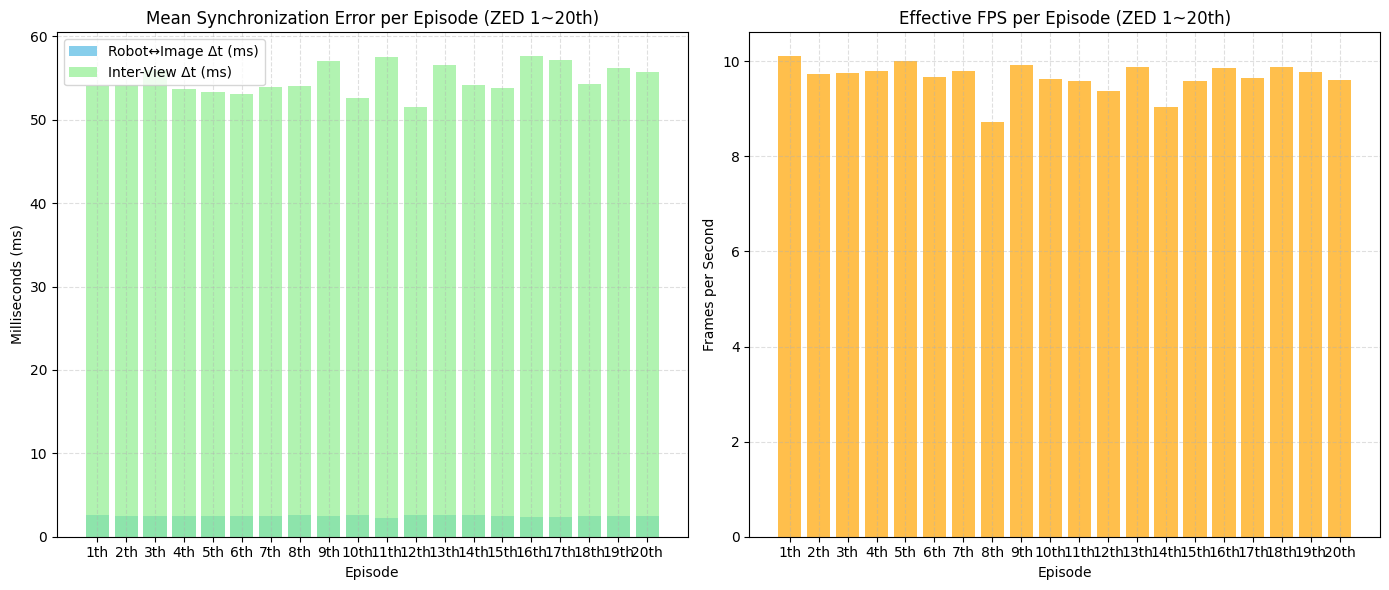

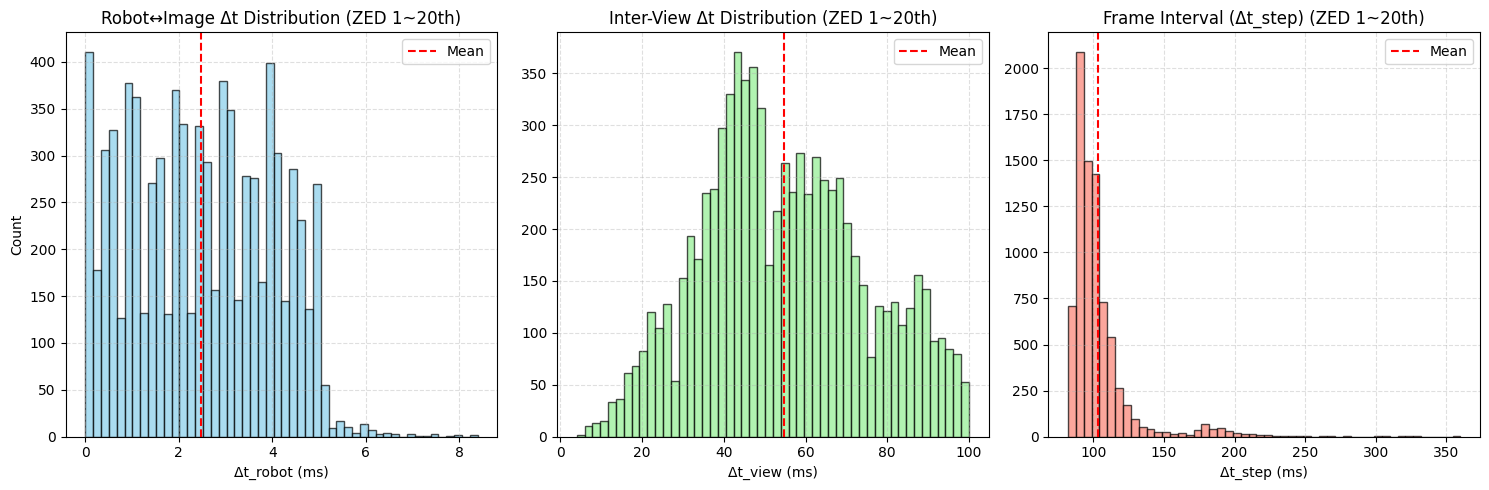

/tmp/ipykernel_2172359/3635701192.py:123: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


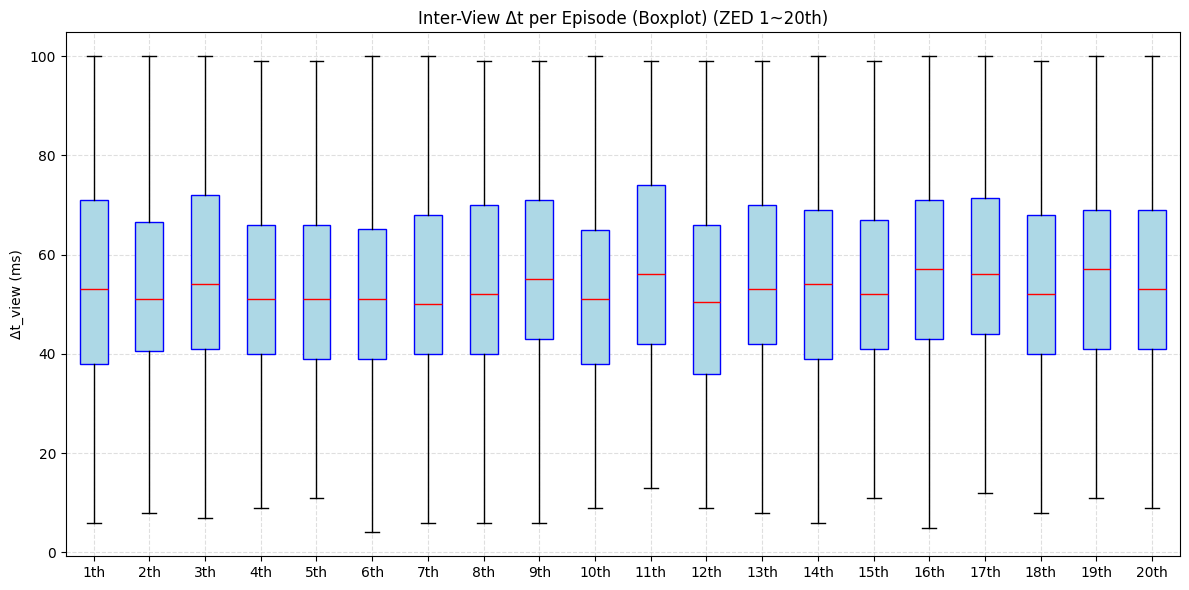


📊 [OCT Insertion (9-View) Dataset]
[OCT_insertion - 1th] Samples=368
  Δt_robot → mean 2.391 ms, max 8.835 ms
  Δt_view  → mean 84.060 ms, max 149.000 ms
  Effective FPS ≈ 6.00

[OCT_insertion - 2th] Samples=170
  Δt_robot → mean 2.356 ms, max 7.127 ms
  Δt_view  → mean 81.835 ms, max 149.000 ms
  Effective FPS ≈ 5.84

[OCT_insertion - 3th] Samples=344
  Δt_robot → mean 2.281 ms, max 9.223 ms
  Δt_view  → mean 80.488 ms, max 149.000 ms
  Effective FPS ≈ 5.77

[OCT_insertion - 4th] Samples=182
  Δt_robot → mean 2.346 ms, max 6.991 ms
  Δt_view  → mean 87.549 ms, max 148.000 ms
  Effective FPS ≈ 6.07

[OCT_insertion - 5th] Samples=324
  Δt_robot → mean 2.274 ms, max 6.609 ms
  Δt_view  → mean 81.284 ms, max 150.000 ms
  Effective FPS ≈ 5.82

[OCT_insertion - 6th] Samples=315
  Δt_robot → mean 2.344 ms, max 9.802 ms
  Δt_view  → mean 79.794 ms, max 149.000 ms
  Effective FPS ≈ 5.88

[OCT_insertion - 7th] Samples=306
  Δt_robot → mean 2.331 ms, max 7.222 ms
  Δt_view  → mean 81.974 ms, ma

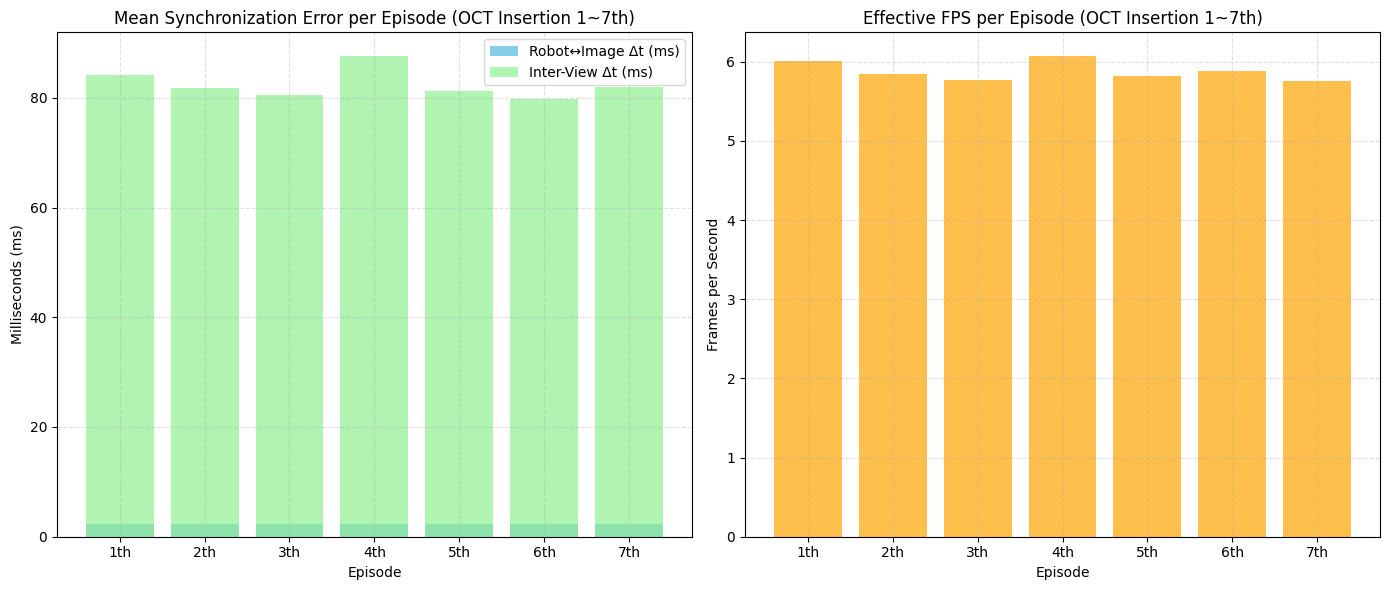

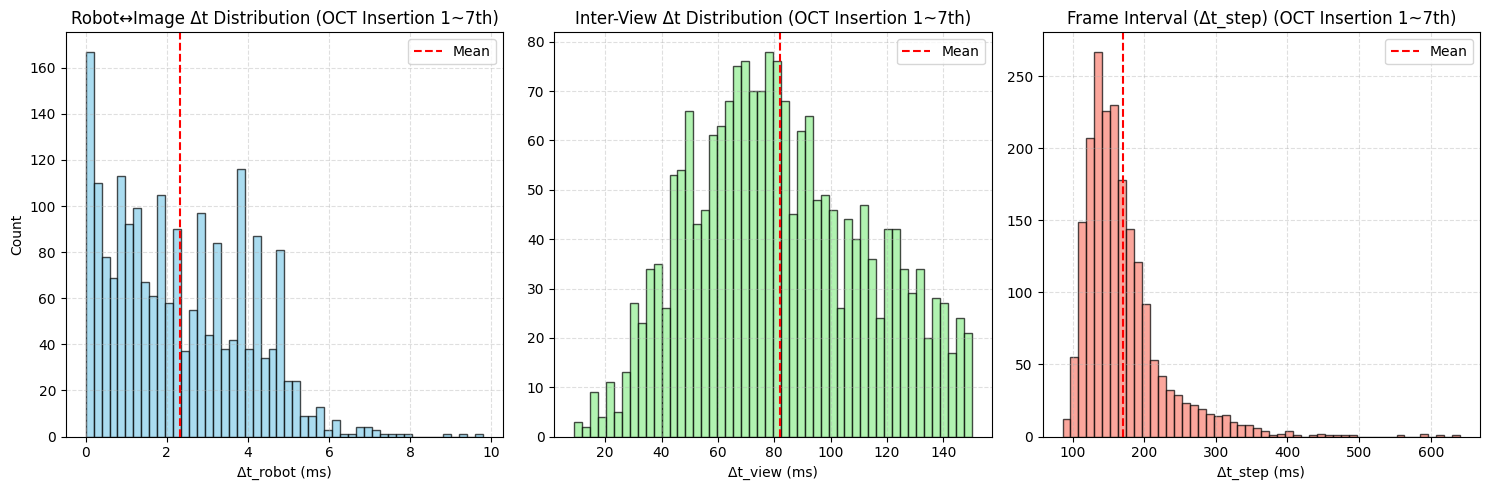

/tmp/ipykernel_2172359/3635701192.py:123: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


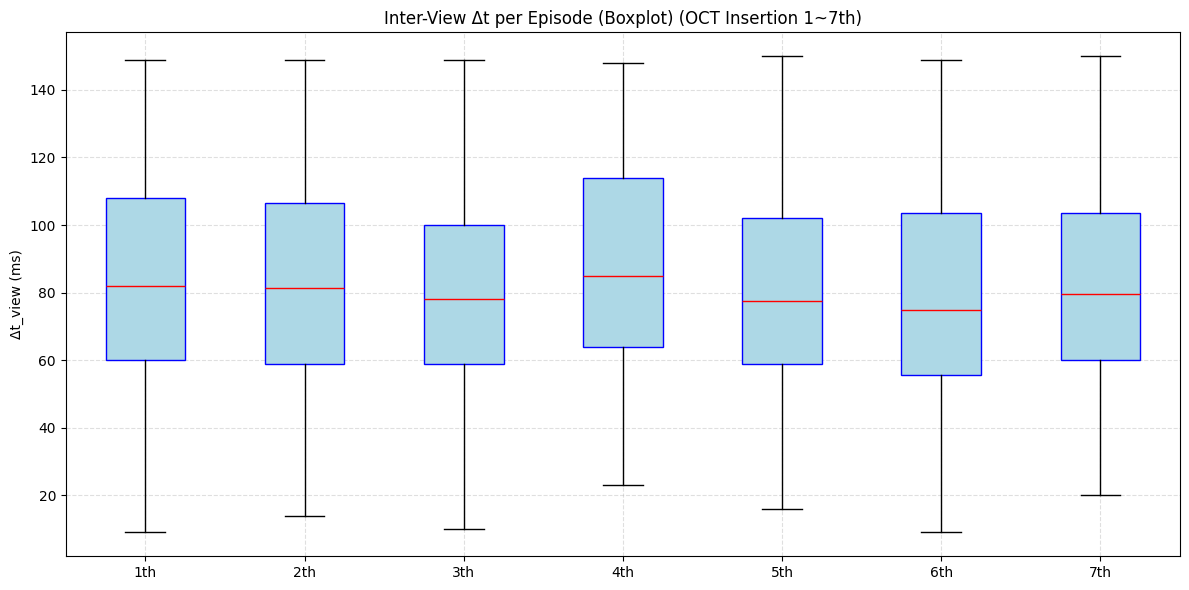


📊 [Combined Dataset (ZED + OCT)]
[part1 - 1th] Samples=442
  Δt_robot → mean 2.596 ms, max 8.395 ms
  Δt_view  → mean 54.029 ms, max 100.000 ms
  Effective FPS ≈ 10.10

[part1 - 2th] Samples=427
  Δt_robot → mean 2.448 ms, max 6.711 ms
  Δt_view  → mean 54.136 ms, max 100.000 ms
  Effective FPS ≈ 9.74

[part1 - 3th] Samples=428
  Δt_robot → mean 2.491 ms, max 7.430 ms
  Δt_view  → mean 56.030 ms, max 100.000 ms
  Effective FPS ≈ 9.76

[part1 - 4th] Samples=431
  Δt_robot → mean 2.465 ms, max 6.440 ms
  Δt_view  → mean 53.668 ms, max 99.000 ms
  Effective FPS ≈ 9.80

[part1 - 5th] Samples=440
  Δt_robot → mean 2.433 ms, max 6.596 ms
  Δt_view  → mean 53.314 ms, max 99.000 ms
  Effective FPS ≈ 10.01

[part1 - 6th] Samples=420
  Δt_robot → mean 2.523 ms, max 7.833 ms
  Δt_view  → mean 53.114 ms, max 100.000 ms
  Effective FPS ≈ 9.66

[part1 - 7th] Samples=537
  Δt_robot → mean 2.512 ms, max 8.321 ms
  Δt_view  → mean 53.879 ms, max 100.000 ms
  Effective FPS ≈ 9.79

[part1 - 8th] Samples

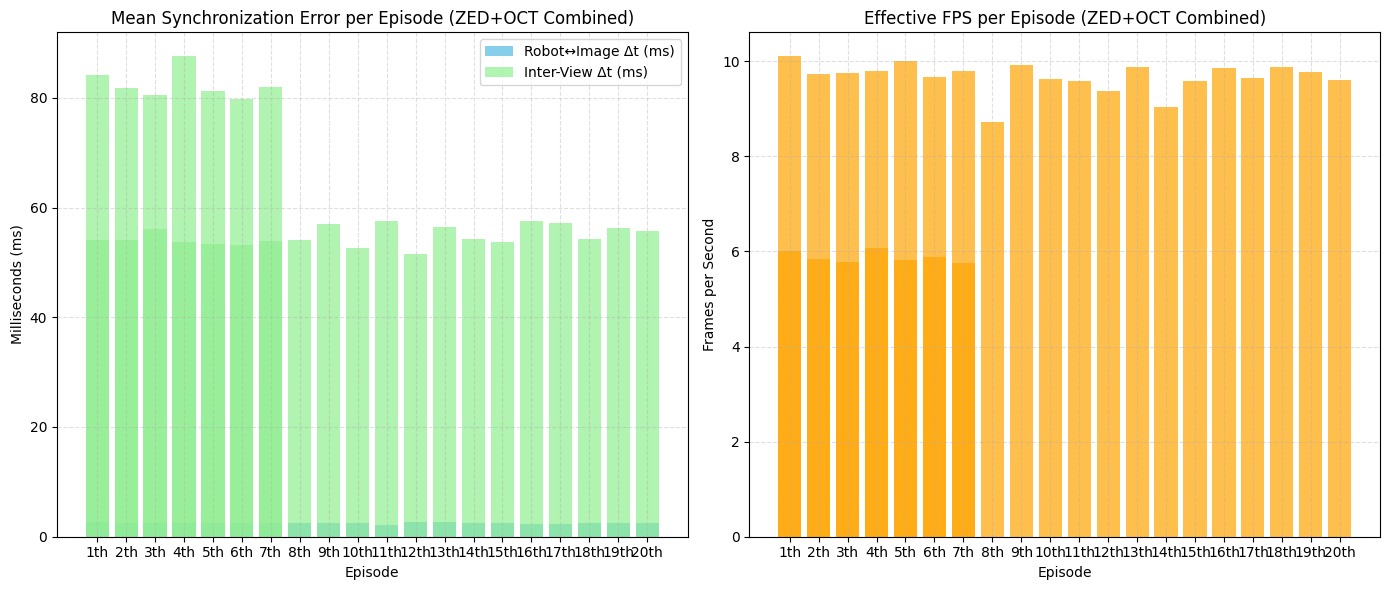

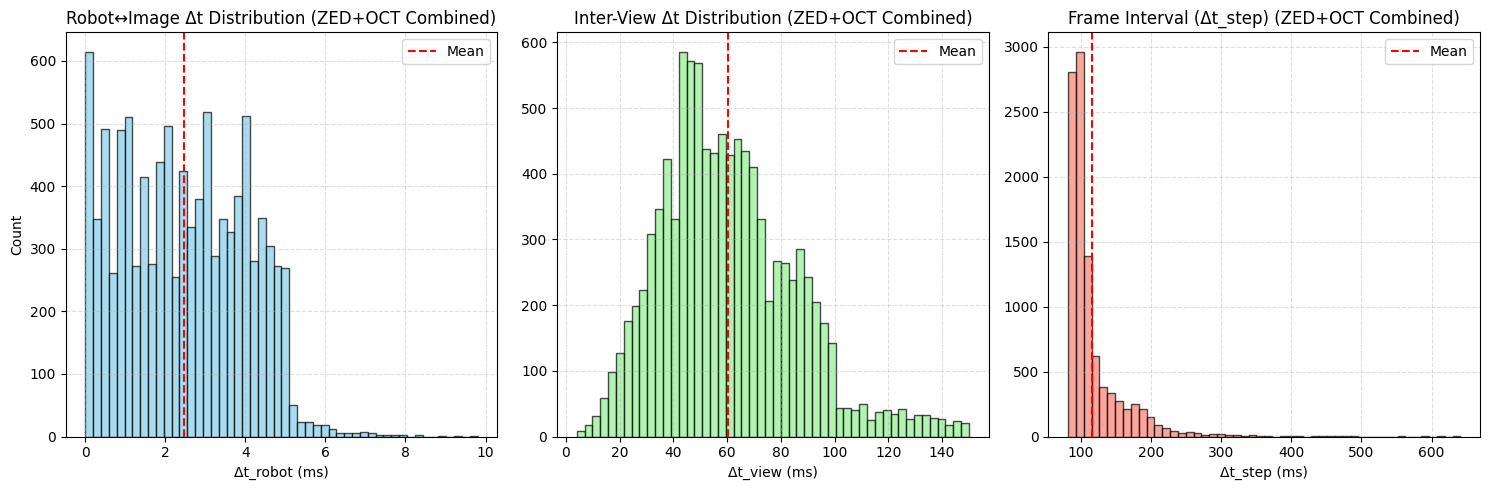

/tmp/ipykernel_2172359/3635701192.py:123: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


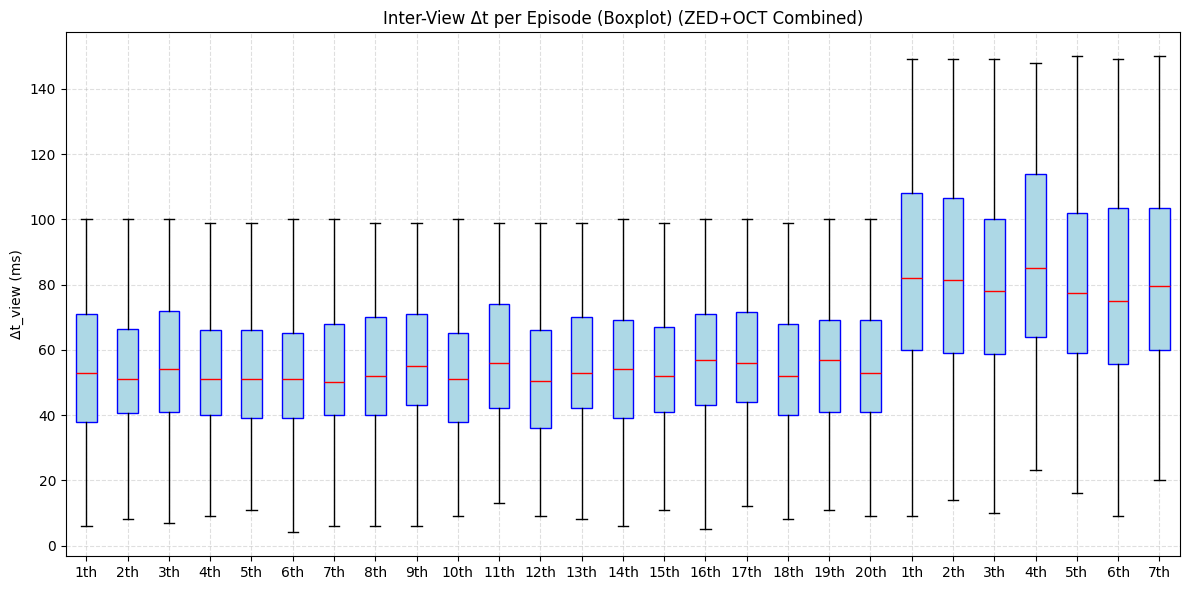

In [44]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# -----------------------------
# 🧩 공통 JSON 로더
# -----------------------------
def load_all_results(base_dirs, pattern="_precise_8views.json", prefix="ZED_Captures_", start_idx=1, end_idx=20):
    stats = []
    for base_dir in base_dirs:
        for i in range(start_idx, end_idx + 1):
            json_path = Path(base_dir) / f"{prefix}{i}th" / f"{prefix}{i}th{pattern}"
            if not json_path.exists():
                # 일부 dataset은 prefix가 다를 수 있음
                continue

            with open(json_path, "r") as f:
                data = json.load(f)
            if len(data) == 0:
                continue

            dt_robot = [d["time_diff_robot"] for d in data]
            dt_view = [d["time_diff_view"] for d in data]
            timestamps = [d["timestamp_ref"] for d in data]
            step_intervals = np.diff(sorted(timestamps)) if len(timestamps) > 1 else []

            stats.append({
                "episode": f"{i}th",
                "part": Path(base_dir).name,
                "num_samples": len(data),
                "dt_robot": np.array(dt_robot),
                "dt_view": np.array(dt_view),
                "step_intervals": step_intervals
            })
    return stats


# -----------------------------
# 🧠 종합 통계 출력
# -----------------------------
def summary_report(stats, title="Synchronization Quality Summary"):
    print(f"\n📊 [{title}]")
    for s in stats:
        print(f"[{s['part']} - {s['episode']}] Samples={s['num_samples']}")
        print(f"  Δt_robot → mean {np.mean(s['dt_robot'])*1000:.3f} ms, max {np.max(s['dt_robot'])*1000:.3f} ms")
        print(f"  Δt_view  → mean {np.mean(s['dt_view'])*1000:.3f} ms, max {np.max(s['dt_view'])*1000:.3f} ms")
        if len(s["step_intervals"]) > 0:
            fps = 1 / np.mean(s["step_intervals"])
            print(f"  Effective FPS ≈ {fps:.2f}\n")
        else:
            print("  No valid timestamps for FPS calculation.\n")


# -----------------------------
# 📈 시각화 함수들
# -----------------------------
def plot_overall_statistics(stats, title_suffix=""):
    episodes = [s["episode"] for s in stats]
    mean_robot = [np.mean(s["dt_robot"]) * 1000 for s in stats]
    mean_view = [np.mean(s["dt_view"]) * 1000 for s in stats]
    fps_mean = [1 / np.mean(s["step_intervals"]) if len(s["step_intervals"]) else 0 for s in stats]

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.bar(episodes, mean_robot, color="skyblue", label="Robot↔Image Δt (ms)")
    plt.bar(episodes, mean_view, color="lightgreen", label="Inter-View Δt (ms)", alpha=0.7)
    plt.title(f"Mean Synchronization Error per Episode {title_suffix}")
    plt.xlabel("Episode")
    plt.ylabel("Milliseconds (ms)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.4)

    plt.subplot(1, 2, 2)
    plt.bar(episodes, fps_mean, color="orange", alpha=0.7)
    plt.title(f"Effective FPS per Episode {title_suffix}")
    plt.xlabel("Episode")
    plt.ylabel("Frames per Second")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()


def plot_distributions(stats, title_suffix=""):
    all_robot = np.concatenate([s["dt_robot"] for s in stats])
    all_view = np.concatenate([s["dt_view"] for s in stats])
    all_steps = np.concatenate([s["step_intervals"] for s in stats if len(s["step_intervals"]) > 0])

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.hist(all_robot * 1000, bins=50, color="skyblue", edgecolor="black", alpha=0.7)
    plt.axvline(np.mean(all_robot) * 1000, color="r", linestyle="--", label="Mean")
    plt.title(f"Robot↔Image Δt Distribution {title_suffix}")
    plt.xlabel("Δt_robot (ms)")
    plt.ylabel("Count")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.4)

    plt.subplot(1, 3, 2)
    plt.hist(all_view * 1000, bins=50, color="lightgreen", edgecolor="black", alpha=0.7)
    plt.axvline(np.mean(all_view) * 1000, color="r", linestyle="--", label="Mean")
    plt.title(f"Inter-View Δt Distribution {title_suffix}")
    plt.xlabel("Δt_view (ms)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.4)

    plt.subplot(1, 3, 3)
    plt.hist(all_steps * 1000, bins=50, color="salmon", edgecolor="black", alpha=0.7)
    plt.axvline(np.mean(all_steps) * 1000, color="r", linestyle="--", label="Mean")
    plt.title(f"Frame Interval (Δt_step) {title_suffix}")
    plt.xlabel("Δt_step (ms)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.4)

    plt.tight_layout()
    plt.show()


def boxplot_sync(stats, title_suffix=""):
    plt.figure(figsize=(12, 6))
    plt.boxplot(
        [s["dt_view"] * 1000 for s in stats],
        labels=[s["episode"] for s in stats],
        patch_artist=True,
        boxprops=dict(facecolor="lightblue", color="blue"),
        medianprops=dict(color="red"),
    )
    plt.title(f"Inter-View Δt per Episode (Boxplot) {title_suffix}")
    plt.ylabel("Δt_view (ms)")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()


# -----------------------------
# 🚀 실행 파이프라인
# -----------------------------
# 1️⃣ ZED 멀티뷰 데이터 (1~20th)
part_dirs = [
    "/home/najo/NAS/VLA/dataset/part1",
    "/home/najo/NAS/VLA/dataset/part2"
]

zed_stats = load_all_results(part_dirs, pattern="_precise_8views.json", prefix="ZED_Captures_", start_idx=1, end_idx=20)
summary_report(zed_stats, "ZED Multi-View Dataset")
plot_overall_statistics(zed_stats, "(ZED 1~20th)")
plot_distributions(zed_stats, "(ZED 1~20th)")
boxplot_sync(zed_stats, "(ZED 1~20th)")

# 2️⃣ OCT Insertion 데이터 (1~7, 9-view)
oct_base = Path("/home/najo/NAS/VLA/dataset/OCT_insertion")
oct_stats = []
for i in range(1, 8):
    json_path = oct_base / f"Captures{i}" / f"Captures{i}_precise_9views.json"
    if not json_path.exists():
        print(f"⚠️ Missing {json_path}")
        continue

    with open(json_path, "r") as f:
        data = json.load(f)
    if len(data) == 0:
        continue

    dt_robot = [d["time_diff_robot"] for d in data]
    dt_view = [d["time_diff_view"] for d in data]
    timestamps = [d["timestamp_ref"] for d in data]
    step_intervals = np.diff(sorted(timestamps)) if len(timestamps) > 1 else []

    oct_stats.append({
        "episode": f"{i}th",
        "part": "OCT_insertion",
        "num_samples": len(data),
        "dt_robot": np.array(dt_robot),
        "dt_view": np.array(dt_view),
        "step_intervals": step_intervals
    })

summary_report(oct_stats, "OCT Insertion (9-View) Dataset")
plot_overall_statistics(oct_stats, "(OCT Insertion 1~7th)")
plot_distributions(oct_stats, "(OCT Insertion 1~7th)")
boxplot_sync(oct_stats, "(OCT Insertion 1~7th)")

# 3️⃣ 두 데이터 통합 분석 (비교)
combined = zed_stats + oct_stats
summary_report(combined, "Combined Dataset (ZED + OCT)")
plot_overall_statistics(combined, "(ZED+OCT Combined)")
plot_distributions(combined, "(ZED+OCT Combined)")
boxplot_sync(combined, "(ZED+OCT Combined)")


### LeRobot Dataset Make

In [1]:
import json, os

def convert_to_lerobot_format(input_json, output_json):
    with open(input_json, "r") as f:
        data = json.load(f)

    lerobot_data = []
    for i, frame in enumerate(data):
        obs = frame["robot_state"]
        step = {
            "timestamp": frame["timestamp"],
            "observation": {
                "image": frame["image"],
                "joint_positions": obs["joint_angles"],
                "ee_pose": obs["ee_pose"]
            },
            # ✅ action은 다음 step joint - 현재 step joint로 근사 (diff-based)
            "action": (
                [b - a for a, b in zip(obs["joint_angles"], data[i+1]["robot_state"]["joint_angles"])]
                if i < len(data)-1 else [0]*len(obs["joint_angles"])
            ),
            "reward": 0.0,
            "done": i == len(data)-1
        }
        lerobot_data.append(step)

    os.makedirs(os.path.dirname(output_json), exist_ok=True)
    with open(output_json, "w") as f:
        json.dump(lerobot_data, f, indent=2)
    print(f"✅ Saved {len(lerobot_data)} steps to {output_json}")

convert_to_lerobot_format(
    "/home/najo/NAS/VLA/dataset/part1/ZED_Captures_1th/ZED_Captures_1th_view1_left_single.json",
    "lerobot_dataset/episode_000/data.json"
)


✅ Saved 449 steps to lerobot_dataset/episode_000/data.json


In [3]:
import pandas as pd
import pyarrow as pa, pyarrow.parquet as pq

def json_to_parquet(json_path, parquet_path):
    with open(json_path, "r") as f:
        data = json.load(f)
    df = pd.DataFrame(data)
    pq.write_table(pa.Table.from_pandas(df), parquet_path)
    print(f"✅ Parquet saved: {parquet_path}")

json_to_parquet(
    "lerobot_dataset/episode_000/data.json",
    "lerobot_dataset/episode_000/data.parquet"
)

✅ Parquet saved: lerobot_dataset/episode_000/data.parquet


In [12]:
import os, json

def make_info_json(dataset_root):
    info_path = os.path.join(dataset_root, "info.json")
    os.makedirs(dataset_root, exist_ok=True)
    data_dir = os.path.join(dataset_root, "data")
    os.makedirs(data_dir, exist_ok=True)

    info = {
        "repo_id": os.path.basename(dataset_root),
        "features": {
            "observation.image": {"dtype": "string"},
            "observation.joint_positions": {"dtype": "float32", "shape": [6]},
            "observation.ee_pose": {"dtype": "float32", "shape": [6]},
            "action": {"dtype": "float32", "shape": [6]},
            "reward": {"dtype": "float32"},
            "done": {"dtype": "bool"}
        },
        "splits": ["train"],
        "version": "1.0.0"
    }

    with open(info_path, "w") as f:
        json.dump(info, f, indent=2)
    print(f"✅ Created info.json at {info_path}")

make_info_json("/home/najo/NAS/VLA/VLA_insertion/lerobot_dataset")


✅ Created info.json at /home/najo/NAS/VLA/VLA_insertion/lerobot_dataset/info.json


In [20]:
!huggingface-cli repo create meca500_insertion --type dataset

The --type argument is deprecated and will be removed in a future version. Use --repo-type instead.
⚠️  Warning: 'huggingface-cli repo' is deprecated. Use 'hf repo' instead.
Successfully created Najongs/meca500_insertion on the Hub.
Your repo is now available at https://huggingface.co/datasets/Najongs/meca500_insertion


In [21]:
from datasets import Dataset, DatasetDict
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import os

root = "/home/najo/NAS/VLA/VLA_insertion/lerobot_dataset/data"

# 모든 parquet 파일 불러오기
dfs = []
for f in os.listdir(root):
    if f.endswith(".parquet"):
        df = pd.read_parquet(os.path.join(root, f))
        dfs.append(df)

# 병합 (또는 에피소드별 분리 가능)
df_all = pd.concat(dfs, ignore_index=True)
hf_dataset = Dataset.from_pandas(df_all)

In [27]:
from huggingface_hub import HfApi
api = HfApi()
api.upload_folder(
    folder_path="/home/najo/NAS/VLA/VLA_insertion/lerobot_dataset",
    repo_id="Najongs/meca500_insertion",
    repo_type="dataset"
)

Processing Files (1 / 1): 100%|██████████| 70.1kB / 70.1kB, 43.8kB/s  
New Data Upload: 100%|██████████| 70.1kB / 70.1kB, 43.8kB/s  


CommitInfo(commit_url='https://huggingface.co/datasets/Najongs/meca500_insertion/commit/fac32cb3258c8ce43d476bb6c5f6ff86afc0c594', commit_message='Upload folder using huggingface_hub', commit_description='', oid='fac32cb3258c8ce43d476bb6c5f6ff86afc0c594', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/Najongs/meca500_insertion', endpoint='https://huggingface.co', repo_type='dataset', repo_id='Najongs/meca500_insertion'), pr_revision=None, pr_num=None)

In [31]:
import sys
from pathlib import Path

# ✅ lerobot 소스 경로 추가
LEROBOT_SRC = Path("/home/najo/NAS/VLA/lerobot/src")
if str(LEROBOT_SRC) not in sys.path:
    sys.path.append(str(LEROBOT_SRC))

from pprint import pprint
import torch
from huggingface_hub import HfApi

import lerobot
from lerobot.datasets.lerobot_dataset import LeRobotDataset, LeRobotDatasetMetadata

dataset = LeRobotDataset(
    repo_id="Najongs/meca500_insertion",
    root="/home/najo/NAS/VLA/VLA_insertion/lerobot_dataset"
)

print("✅ Dataset length:", len(dataset))
print("Keys:", dataset[0].keys())





NotImplementedError: Contact the maintainer on [Discord](https://discord.com/invite/s3KuuzsPFb).

In [ ]:
from datasets import Dataset, Features, Image, Value, Sequence

data = [
    {"image": "/home/najo/NAS/VLA/dataset/part1/ZED_Captures_1th/view1/left/zed_41182735_left_1759119496.047.jpg", "action": [0.05, 0.1, 0.0]},
    {"image": "/home/najo/NAS/VLA/dataset/part1/ZED_Captures_1th/view1/left/zed_41182735_left_1759119496.254.jpg", "action": [0.02, 0.1, 0.1]},
]

features = Features({
    "image": Image(),  # <-- 이미지 feature 선언
    "action": Sequence(Value("float32"))
})

dataset = Dataset.from_list(data, features=features)
print(dataset[0])
      

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1920x1200 at 0x7F18B8AACF70>, 'action': [0.05000000074505806, 0.10000000149011612, 0.0]}


In [10]:
dataset.push_to_hub("Najongs/Meca500_testset")

Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 99.15ba/s]
Processing Files (1 / 1): 100%|██████████| 1.14MB / 1.14MB,  440kB/s  
New Data Upload: 100%|██████████| 1.14MB / 1.14MB,  440kB/s  
Uploading the dataset shards: 100%|██████████| 1/1 [00:03<00:00,  3.57s/ shards]


CommitInfo(commit_url='https://huggingface.co/datasets/Najongs/Meca500_testset/commit/278dc7a3f853b36f1633f3c7e2ebb79a33362f51', commit_message='Upload dataset', commit_description='', oid='278dc7a3f853b36f1633f3c7e2ebb79a33362f51', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/Najongs/Meca500_testset', endpoint='https://huggingface.co', repo_type='dataset', repo_id='Najongs/Meca500_testset'), pr_revision=None, pr_num=None)

In [9]:
import sys
from pathlib import Path

# ✅ lerobot 소스 경로 추가
LEROBOT_SRC = Path("/home/najo/NAS/VLA/lerobot/src")
if str(LEROBOT_SRC) not in sys.path:
    sys.path.append(str(LEROBOT_SRC))

from pprint import pprint
import torch
from huggingface_hub import HfApi

import lerobot
from lerobot.datasets.lerobot_dataset import LeRobotDataset, LeRobotDatasetMetadata

print("✅ lerobot imported successfully!")
print("List of available datasets:")
pprint(lerobot.available_datasets)

✅ lerobot imported successfully!
List of available datasets:
['lerobot/aloha_mobile_cabinet',
 'lerobot/aloha_mobile_chair',
 'lerobot/aloha_mobile_elevator',
 'lerobot/aloha_mobile_shrimp',
 'lerobot/aloha_mobile_wash_pan',
 'lerobot/aloha_mobile_wipe_wine',
 'lerobot/aloha_sim_insertion_human',
 'lerobot/aloha_sim_insertion_human_image',
 'lerobot/aloha_sim_insertion_scripted',
 'lerobot/aloha_sim_insertion_scripted_image',
 'lerobot/aloha_sim_transfer_cube_human',
 'lerobot/aloha_sim_transfer_cube_human_image',
 'lerobot/aloha_sim_transfer_cube_scripted',
 'lerobot/aloha_sim_transfer_cube_scripted_image',
 'lerobot/aloha_static_battery',
 'lerobot/aloha_static_candy',
 'lerobot/aloha_static_coffee',
 'lerobot/aloha_static_coffee_new',
 'lerobot/aloha_static_cups_open',
 'lerobot/aloha_static_fork_pick_up',
 'lerobot/aloha_static_pingpong_test',
 'lerobot/aloha_static_pro_pencil',
 'lerobot/aloha_static_screw_driver',
 'lerobot/aloha_static_tape',
 'lerobot/aloha_static_thread_velcro

In [10]:
hub_api = HfApi()
repo_ids = [info.id for info in hub_api.list_datasets(task_categories="robotics", tags=["LeRobot"])]
pprint(repo_ids)


/home/najo/.conda/envs/lerobot/lib/python3.10/site-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in 'list_datasets': tags. Will not be supported from version '1.0'.

Use `filter` instead.
  warnings.warn(message, FutureWarning)


['physical-intelligence/libero',
 'behavior-1k/2025-challenge-demos',
 'lerobot/berkeley_fanuc_manipulation',
 'yaak-ai/L2D-v3',
 'unitreerobotics/G1_Dex3_ToastedBread_Dataset',
 'lerobot/metaworld_mt50',
 'unitreerobotics/Z1_Dual_Dex1_StackBox_Dataset',
 'kantine/eval_act_soldering_3',
 'pollen-robotics/pick_and_place_bottle',
 'noisyduck/ffw_bg2_rev4_tr_conveyor_250830_06',
 'naavox/stringman-practice-dataset-2',
 'lerobot/pusht',
 'lerobot/aloha_sim_insertion_human',
 'lerobot/aloha_sim_insertion_scripted',
 'lerobot/aloha_sim_transfer_cube_human',
 'lerobot/aloha_sim_transfer_cube_scripted',
 'lerobot/xarm_lift_medium',
 'lerobot/xarm_lift_medium_replay',
 'lerobot/xarm_push_medium',
 'lerobot/xarm_push_medium_replay',
 'lerobot/umi_cup_in_the_wild',
 'lerobot/aloha_static_screw_driver',
 'lerobot/aloha_static_candy',
 'lerobot/aloha_static_tape',
 'lerobot/aloha_mobile_wipe_wine',
 'lerobot/aloha_static_thread_velcro',
 'lerobot/aloha_static_battery',
 'lerobot/aloha_static_coffee

In [11]:
repo_id = "lerobot/aloha_mobile_cabinet"
ds_meta = LeRobotDatasetMetadata(repo_id)
dataset = LeRobotDataset(repo_id, episodes=[0, 10, 11, 23])

print(f"Selected episodes: {dataset.episodes}")
print(f"Number of episodes selected: {dataset.num_episodes}")
print(f"Number of frames selected: {dataset.num_frames}")


Fetching 4 files: 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]


local_dir / DEFAULT_TASKS_PATH /home/najo/.cache/huggingface/lerobot/lerobot/aloha_mobile_cabinet/meta/tasks.parquet


Generating train split: 85 examples [00:00, 2169.88 examples/s]


local_dir / DEFAULT_TASKS_PATH /home/najo/.cache/huggingface/lerobot/lerobot/aloha_mobile_cabinet/meta/tasks.parquet


Fetching 4 files: 100%|██████████| 4/4 [00:35<00:00,  8.78s/it]
Generating train split: 127500 examples [00:00, 1114818.05 examples/s]

Selected episodes: [0, 10, 11, 23]
Number of episodes selected: 4
Number of frames selected: 127500


In [ ]:
dataloader = torch.utils.data.DataLoader(
    dataset,
    num_workers=0,
    batch_size=32,
    shuffle=True,
)

for batch in dataloader:
    print(f"{batch[camera_key].shape=}")  # (32, 4, c, h, w)
    print(f"{batch['observation.state'].shape=}")  # (32, 6, c)
    print(f"{batch['action'].shape=}")  # (32, 64, c)
    break



FileNotFoundError: [Errno 2] No such file or directory: '/home/najo/.cache/huggingface/lerobot/lerobot/aloha_mobile_cabinet/videos/observation.images.cam_high/chunk-000/file-001.mp4'